# Example 3: -  DY check with systematics

by Duccio Pappadopulo

Use simple $u ~\bar u \to \mu^+\mu^-$ to test MadMiner treatment of systematics.
It uses `SM4fLL_UFO` model containing $W$ and $Y$ electroweak parameters.

## Preparations

Let us first load all the python libraries again

In [7]:
import sys
import os
madminer_src_path = "/Users/dpappadopulo/Projects/~Physics/madminer"
sys.path.append(madminer_src_path)

from __future__ import absolute_import, division, print_function, unicode_literals

import logging
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
% matplotlib inline

from madminer.core import MadMiner
from madminer.plotting import plot_2d_morphing_basis
from madminer.sampling import combine_and_shuffle
from madminer.lhe import LHEProcessor
from madminer.sampling import SampleAugmenter
from madminer.plotting import plot_distributions, plot_uncertainty

Please enter here the path to your MG5 root directory. This notebook assumes that you installed Delphes and Pythia through MG5. **This needs to be updated by the user**

In [8]:
mg_dir = '/Users/dpappadopulo/Projects/~Physics/MG5_aMC_v2_6_4'
base_dir = '/Users/dpappadopulo/Projects/~Physics/madminer/examples/example4_systematics_DY/'

sample_dir = base_dir + 'data/samples/DY_sys/'
card_dir = base_dir + 'cards/'
ufo_model_dir = card_dir + 'SM4fLL_UFO'
run_card_dir = card_dir + 'run_cards/'
mg_process_dir = base_dir + 'data/mg_processes/DY_sys/'
log_dir = base_dir + 'logs/DY_sys/'
temp_dir = base_dir + 'data/temp'

MadMiner uses the Python `logging` module to provide additional information and debugging output. You can choose how much of this output you want to see by switching the level in the following lines to `logging.DEBUG` or `logging.WARNING`.

In [9]:
logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)

## 1. Setup

### 1a) Parameter Space

Let us first define the theory parameters. We are again using the `SM4fLL_UFO` model 

In [4]:
miner = MadMiner()

miner.add_parameter(
    lha_block='oblique',
    lha_id=1,
    parameter_name='cWhat',
    morphing_max_power=2,
    parameter_range=(-0.01,0.01),
)
miner.add_parameter(
    lha_block='oblique',
    lha_id=2,
    parameter_name='cYhat',
    morphing_max_power=2,
    parameter_range=(-0.01,0.01),
)

13:27 madminer.core        INFO    Added parameter cWhat (LHA: oblique 1, maximal power in squared ME: (2,), range: (-0.01, 0.01))
13:27 madminer.core        INFO    Added parameter cYhat (LHA: oblique 2, maximal power in squared ME: (2,), range: (-0.01, 0.01))


### 1b) Benchmarks

Define SM benchmarks by hand, and scan to find remaining benchmarks.

In [5]:
miner.add_benchmark( {'cWhat':0., 'cYhat':0.}, 'sm')

13:27 madminer.core        INFO    Added benchmark sm: cYhat = 0.00e+00, cWhat = 0.00e+00)


In [6]:
miner.set_morphing(
    include_existing_benchmarks=True,
    n_trials=1000,
    max_overall_power=2
)

13:27 madminer.core        INFO    Optimizing basis for morphing
13:27 madminer.core        INFO    Added benchmark sm: cWhat = 0.00e+00, cYhat = 0.00e+00)
13:27 madminer.core        INFO    Added benchmark morphing_basis_vector_1: cWhat = -9.69e-03, cYhat = 3.53e-03)
13:27 madminer.core        INFO    Added benchmark morphing_basis_vector_2: cWhat = -9.67e-03, cYhat = -7.73e-03)
13:27 madminer.core        INFO    Added benchmark morphing_basis_vector_3: cWhat = 2.37e-03, cYhat = 6.28e-03)
13:27 madminer.core        INFO    Added benchmark morphing_basis_vector_4: cWhat = 9.10e-03, cYhat = -8.37e-03)
13:27 madminer.core        INFO    Added benchmark morphing_basis_vector_5: cWhat = 8.97e-03, cYhat = -8.46e-04)


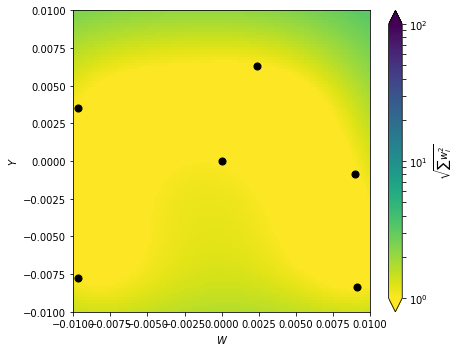

In [7]:
fig = plot_2d_morphing_basis(
    miner.morpher,
    xlabel=r'$W$',
    ylabel=r'$Y$',
    xrange=(-0.01,0.01),
    yrange=(-0.01,0.01)
)

### 1c) Systematics

Systematics can be added using the `madminer.set_systematics()` command. In particular, we consider two sorts of systematics: scale variations and pdf variations. The setting is described by the following three inputs
- `scales`: Whether only the regularization scale (`"mur"`), only the factorization scale (`"muf"`), both simultanously with $\mu=\mu_F=\mu_R$ (`"together"`) or both independently (`"independent"`) are varied.
- `scale_variation`: If not `None`, the regularization and / or factorization scales are varied. A tuple like ($\mu_{max},\mu_{min}$) specifies the factors with which they are varied. Here $\mu_{max}$ refers to the name of the benchmark with $\nu = 1$, while $\mu_{min}$ is either `None` or refers to the name of the benchmark with $\nu = -1$. Note that if more than two scales are given, currently only first and last scale are used.
- `pdf_variation`: If not `None`, the PDFs are varied. The option is passed along to the `--pdf` option of MadGraph's systematics module. See https://cp3.irmp.ucl.ac.be/projects/madgraph/wiki/Systematics for a list. For example, the option `"90900"` would run over all the eigenvectors of the PDF4LHC15_nlo_30 set. 

In [8]:
miner.set_systematics(
    #scale_variation=(0.5,1,2), 
    #scales="independent", 
    pdf_variation="90900",
)

### 1d) Save setup

In [9]:
miner.save(sample_dir + 'madminer_DY.h5')

13:27 madminer.core        INFO    Saving setup (including morphing) to /Users/dpappadopulo/Projects/~Physics/madminer/examples/example4_systematics_DY/data/samples/DY_sys/madminer_DY.h5


## 2. Event Generation

### Create run cards

In [39]:
# binning for dimuon invariant mass
mll_ticks = np.array([300, 360, 430, 520, 620, 750, 900, 1070, 1290, 1550, 1860, 2230, 2670, 3210, 3850, 4620, 5550, 6660, 7990])

mll_bin_1 = mll_ticks[:-1]
mll_bin_2 = mll_ticks[1:]
mll_bins = np.array(zip(mll_bin_1, mll_bin_2))

In [11]:
import shutil
import fileinput

run_card_filenames = []
for i in range(len(mll_bins)):
    run_card_filename = run_card_dir+'/run_card_{}.dat'.format(i)
    print(run_card_filename)
    run_card_filenames.append(run_card_filename)
    shutil.copy(card_dir + 'run_card_default.dat', run_card_filename)    

for i in range(len(mll_bins)):
    f = fileinput.FileInput(run_card_dir+'/run_card_{}.dat'.format(i), inplace=True)
    for line in f:
        print(line.replace('0.0   = mmll    ! min invariant mass of l+l- (same flavour) lepton pair', 
                            '{}   = mmll    ! min invariant mass of l+l- (same flavour) lepton pair'.format(mll_bins[i][0])), end='')
    f.close
    f =  fileinput.FileInput(run_card_dir+'/run_card_{}.dat'.format(i), inplace=True)
    for line in f:
        print(line.replace('-1.0  = mmllmax ! max invariant mass of l+l- (same flavour) lepton pair', 
                            '{}  = mmllmax ! max invariant mass of l+l- (same flavour) lepton pair'.format(mll_bins[i][1])), end='')
    f.close

/Users/dpappadopulo/Projects/~Physics/madminer/examples/example4_systematics_DY/cards/run_cards//run_card_0.dat
/Users/dpappadopulo/Projects/~Physics/madminer/examples/example4_systematics_DY/cards/run_cards//run_card_1.dat
/Users/dpappadopulo/Projects/~Physics/madminer/examples/example4_systematics_DY/cards/run_cards//run_card_2.dat
/Users/dpappadopulo/Projects/~Physics/madminer/examples/example4_systematics_DY/cards/run_cards//run_card_3.dat
/Users/dpappadopulo/Projects/~Physics/madminer/examples/example4_systematics_DY/cards/run_cards//run_card_4.dat
/Users/dpappadopulo/Projects/~Physics/madminer/examples/example4_systematics_DY/cards/run_cards//run_card_5.dat
/Users/dpappadopulo/Projects/~Physics/madminer/examples/example4_systematics_DY/cards/run_cards//run_card_6.dat
/Users/dpappadopulo/Projects/~Physics/madminer/examples/example4_systematics_DY/cards/run_cards//run_card_7.dat
/Users/dpappadopulo/Projects/~Physics/madminer/examples/example4_systematics_DY/cards/run_cards//run_car

Load MadMiner again

In [12]:
miner.load(sample_dir + 'madminer_DY.h5')

13:31 madminer.core        INFO    Found 2 parameters:
13:31 madminer.core        INFO       cWhat (LHA: oblique 1, maximal power in squared ME: (2,), range: (-0.01, 0.01))
13:31 madminer.core        INFO       cYhat (LHA: oblique 2, maximal power in squared ME: (2,), range: (-0.01, 0.01))
13:31 madminer.core        INFO    Found 6 benchmarks:
13:31 madminer.core        INFO       sm: cWhat = 0.00e+00, cYhat = 0.00e+00
13:31 madminer.core        INFO       morphing_basis_vector_1: cWhat = -9.69e-03, cYhat = 3.53e-03
13:31 madminer.core        INFO       morphing_basis_vector_2: cWhat = -9.67e-03, cYhat = -7.73e-03
13:31 madminer.core        INFO       morphing_basis_vector_3: cWhat = 2.37e-03, cYhat = 6.28e-03
13:31 madminer.core        INFO       morphing_basis_vector_4: cWhat = 9.10e-03, cYhat = -8.37e-03
13:31 madminer.core        INFO       morphing_basis_vector_5: cWhat = 8.97e-03, cYhat = -8.46e-04
13:31 madminer.core        INFO    Found morphing setup with 6 components
13:31 ma

We now run MadMiner for the signal: 

In [13]:
benchmarks = ['sm']

In [14]:
miner.run_multiple(
    mg_directory=mg_dir,
    proc_card_file=card_dir + 'proc_card_mg5.dat',
    param_card_template_file=card_dir + 'param_card.dat',
    pythia8_card_file=None,
    run_card_files=run_card_filenames,
    mg_process_directory=mg_process_dir,
    ufo_model_directory=ufo_model_dir,
    temp_directory=temp_dir,
    sample_benchmarks=benchmarks,
    is_background=False,
    only_prepare_script=False,
    #initial_command='source activate python2',
    log_directory=log_dir
)

13:32 madminer.utils.inter INFO    Generating MadGraph process folder from /Users/dpappadopulo/Projects/~Physics/madminer/examples/example4_systematics_DY/cards/proc_card_mg5.dat at /Users/dpappadopulo/Projects/~Physics/madminer/examples/example4_systematics_DY/data/mg_processes/DY_sys/
13:32 madminer.core        INFO    Run 0
13:32 madminer.core        INFO      Sampling from benchmark: sm
13:32 madminer.core        INFO      Original run card:       /Users/dpappadopulo/Projects/~Physics/madminer/examples/example4_systematics_DY/cards/run_cards//run_card_0.dat
13:32 madminer.core        INFO      Original Pythia8 card:   None
13:32 madminer.core        INFO      Copied run card:         /madminer/cards/run_card_0.dat
13:32 madminer.core        INFO      Copied Pythia8 card:     None
13:32 madminer.core        INFO      Param card:              /madminer/cards/param_card_0.dat
13:32 madminer.core        INFO      Reweight card:           /madminer/cards/reweight_card_0.dat
13:32 madmin

## 3. Extract Parton Level Observables / Weights 

### 3a) Setting up LHEProcessor 

We first initialize the the LHEProcessor and add the LHE file

In [4]:
lhep = LHEProcessor(sample_dir + 'madminer_DY.h5')

run_folders = [base_dir + 'data/mg_processes/DY_sys/Events/run_{:02d}/'.format(i) for i in range(1,19)]

for folder in run_folders:
    lhep.add_sample(
        folder + 'unweighted_events.lhe.gz',
        sampled_from_benchmark="sm",
        k_factor=1.0
    )

### 3b) Smearing Functions

Instead of performing a proper proper shower and detector simulation, we can simulate smearing effects at parton level smearing through smearing functions. Here we will assume a simple 10% uncertainty on the tau energy measurements and a $\pm 0.05$ smearing for tau $\eta$ and $\phi$. The transverse momenta of the taus are then derived from the smeared energy and the on-shell condition for the quarks (this is what `pt_resolution_abs=None` does). The leptons from the Z-boson decay are assumed to be measured perfectly (otherwise we'd have to call `set_smearing` another time with `pdgis=[-13 13]`).

In [13]:
"""
lhep.set_smearing(
    pdgids=[-15, 15],   
    energy_resolution_abs=0.05,
    energy_resolution_rel=0,
    pt_resolution_abs=None,
    pt_resolution_rel=None,
    eta_resolution_abs=0.02,
    eta_resolution_rel=0,
    phi_resolution_abs=0.02,
    phi_resolution_rel=0,
)
"""

### 3c) Add Observables and Cuts

We will now add some observables.  In the expression string, you can use the terms `j[i]`, `e[i]`, `mu[i]`, `tau[i]`,  `a[i]`, `met`, where the indices `i` refer to a ordering by the transverse momentum. In addition, you can use `p[i]`, which denotes the `i`-th particle in the order given in the LHE sample (which is the order in which the final-state particles where defined in MadGraph).

Here we on a small set of higher-level observables: 

In [5]:
lhep.add_observable('mll', '(mu[0]+mu[1]).m',required=True)
lhep.add_observable('pt_mu', 'p[0].pt',required=True)
lhep.add_observable('eta_mu', 'mu[0].eta',required=True)

### 3d) Run and Save 

We can now run `analyse_samples` to calculate all observables from the LHE file(s) generated before, apply the smearing, and check which events pass the cuts:

In [ ]:
lhep.analyse_samples() 

Finally, let's save everything

In [18]:
lhep.save('data/madminer_lhedata_signal.h5')

In [10]:
lhep = LHEProcessor('data/madminer_lhedata_signal.h5')


### 3e) Plot Distributions

Let us now plot some distributions. This can also be done using the `plot_distributions` function. As before the function requires
- `filename`: the name of the file with the processed LHE data
- `parameter_points`: a list of benchmarks, which can either be specified by there name (such as `sm`) or manually (for example `np.array([0,1])`). 
- `line_labels`: names for the benchmarks
- `observables`: list of observables to be plotted (when `None`, all observables are plotted)
We can also plot the uncertainties using the option `uncertainties='nuisance'`. By default, the full uncertainy band using all considered nuicanse parameter is shown. To obtain the uncertainty, MadMiner created a set of `n_toys` (default 100) Monte Carlo sample distributions to estimate the 68% CL band. Additionally, MadMiner can also show a set of `N` of these Monte Carlo toy samples using the option `draw_nuisance_toys=N`. 

More options, in particular regarding plotting, can be found via the command `help(plot_distributions)`. 

23:57 madminer.sampling    INFO    Loading data from data/madminer_lhedata_signal.h5
23:57 madminer.sampling    INFO    Found 2 parameters
23:57 madminer.sampling    INFO    Found 31 nuisance parameters
23:57 madminer.sampling    INFO    Found 81 benchmarks, of which 6 physical
23:57 madminer.sampling    INFO    Found 3 observables
23:57 madminer.sampling    INFO    Found 900000 events
23:57 madminer.sampling    INFO    Found morphing setup with 6 components
23:57 madminer.sampling    INFO    Found nuisance morphing setup


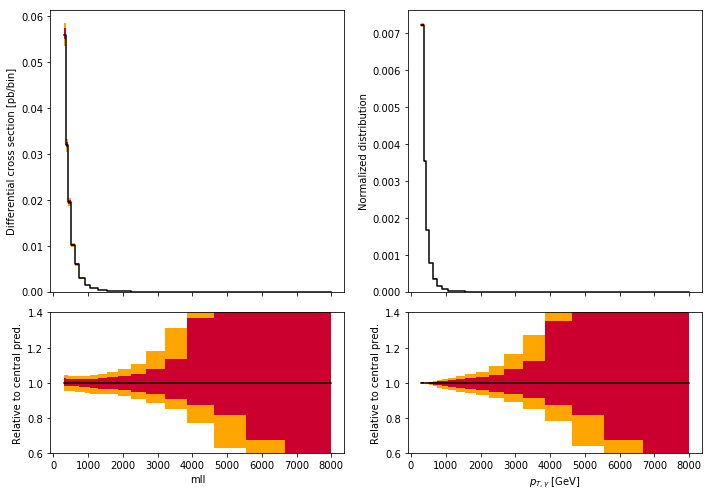

In [42]:
fig = plot_uncertainty(
    filename='data/madminer_lhedata_signal.h5',
    theta = np.array([0,0]),
    observable='mll',
    obs_label = 'mll',
    obs_range = (1000,7900),
    n_bins=mll_ticks ,  
    ratio_range = (1-0.4,1+ 0.4)
)

18:36 madminer.sampling    INFO    Loading data from data/madminer_lhedata_signal.h5
18:36 madminer.sampling    INFO    Found 2 parameters
18:36 madminer.sampling    INFO    Found 31 nuisance parameters
18:36 madminer.sampling    INFO    Found 81 benchmarks, of which 6 physical
18:36 madminer.sampling    INFO    Found 3 observables
18:36 madminer.sampling    INFO    Found 900000 events
18:36 madminer.sampling    INFO    Found morphing setup with 6 components
18:36 madminer.sampling    INFO    Found nuisance morphing setup
18:36 madminer.plotting    WARNING Removed 18908 / 900000 events with negative weights


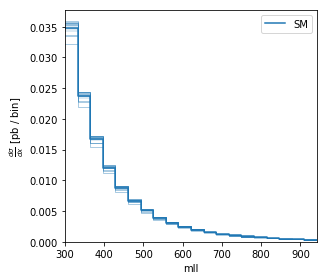

In [6]:
fig = plot_distributions(
    filename='data/madminer_lhedata_signal.h5',
    parameter_points=['sm'],
    line_labels=['SM'],
    observables=['mll'],
    uncertainties='nuisance',
    n_toys=100,
    n_bins=20 ,               
    #normalize=True, 
    #log=True,
    #n_events=1000
    draw_nuisance_toys=10,
)